## Mixture Kernel With non-stationary local weight

The Gaussian process in consideration is a mixture of independent processes. In specific, there is one global process $\mathcal{GP}_{g}$ and a collection of local processes $\{\mathcal{GP}_{l_i}\}$. A local non-stationary weight is added to each of the processes, to balance between exploring with global process and exploiting with local processes. The weight is modeled as Gaussian functions, to give the expression below:
\begin{gather*}
    f(\mathbf{x}) = e^{-\frac{\lVert \mathbf{x}-\pmb{\psi_g}\rVert_2^2}{2*\sigma_g^2}} f_{g}(\mathbf{x}) + \sum_i e^{-\frac{\lVert \mathbf{x}-\pmb{\psi_l}\rVert_2^2}{2*\sigma_{l_i}^2}} f_{l_i}(\mathbf{x}),\\
    f_{g} \sim \mathcal{GP}_{g},\quad f_{l_i} \sim \mathcal{GP}_{l_i},
\end{gather*}

$\pmb{\psi}$ denotes the position of the center of the influence region of a process.

Additivity of Gaussian processes results in the sum being Gaussian processes. If we further assume no correlation between the $\mathcal{GP}$ s, then we may describe $\mathcal{GP}_{tot}:\ f(\mathbf{x})\sim\mathcal{GP}_{tot}$ uniquely with mean function and covariance kernel as:

\begin{align*}
    k(\mathbf x_1, \mathbf x_2) = &\exp\left(\frac{\lVert \mathbf{x_1}-\pmb{\psi_g}\rVert_2^2 + \lVert \mathbf{x_2}-\pmb{\psi_g}\rVert_2^2}{2\sigma_g^2}\right)k_g(\mathbf x_1, \mathbf x_2)\\
    &+\sum_i \exp\left(\frac{\lVert \mathbf{x_1}-\pmb{\psi_g}\rVert_2^2 + \lVert \mathbf{x_2}-\pmb{\psi_g}\rVert_2^2}{2\sigma_{l_i}^2}\right)k_{l_i}(\mathbf x_1, \mathbf x_2),\\
        m(\mathbf x) = & m_g(\mathbf{x}) + \sum_i m_{l_i}(\mathbf{x}) 
\end{align*}


Our assumptions are: 1). Local Kernels are at a same place, and the areas of influence are isotropic. 2). input of $\mathbf x$ is vaguely standardized to $[-1,1]_d$, which can be used for setting the priors of sub-kernel hyperparameters and position/weights hyperparameters. 3). Global kernel has near uniform weight, which can be simulated by placing at $\pmb{\psi_g} = [0.5]_d$ and $\sigma_g$ being large, e.g. taken to be 10. 4). Global weight $\sigma_g$ isn't a hyperparameter, while local weights $\sigma_{l_i}$ s are hyperparameters. If necessary, we can use a unified $\sigma_{l}$. 5). To emphasize the local/global weights, $\sigma_l \ll \sigma_g$ might also be necessary. The practical hyperparameter might be $\sigma_l/\sigma_g$, constrained to $(0,1)$, or its logarithm constrained to $(-\infty,0)$, instead of $\sigma_l$.

----

The following cell is the Spartan Kernel's code:



In [1]:
from typing import Optional, Tuple
import gpytorch
from gpytorch.constraints import Interval
from gpytorch.priors import Prior
import torch
from torch._C import Size
from torch.nn import ModuleList
from ast import match_case
from math import sqrt
from statistics import linear_regression
from typing import Iterable
from gpytorch.kernels import Kernel
from linear_operator.operators import ZeroLinearOperator
from gpytorch.distributions import MultivariateNormal


class SpartanKernel(Kernel):

        has_lengthscale = False

        def __init__(self, global_kernel: Kernel, local_kernels: Iterable[Kernel], 
                     ard_num_dims: int = 1,
                     local_position_prior: Optional[Prior] = None,
                     local_position_constraint: Optional[Interval] = None,
                     eps: float = 0.000001, **kwargs):
                
                
                super(SpartanKernel, self).__init__(ard_num_dims=ard_num_dims)

                self.global_kernel = global_kernel
                self.local_kernels = ModuleList(local_kernels)
                self.register_parameter(
                        name="raw_local_position", 
                        parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape,1,ard_num_dims))
                )
                if local_position_prior is not None:
                        if not isinstance(local_position_prior, Prior):
                                raise TypeError("Expected gpytorch.priors.Prior but got " + type(local_position_prior).__name__)
                        self.register_prior(
                                "local_position_prior",
                                local_position_prior,
                                lambda m: m.local_position,
                                lambda m, v: m._set_local_position(v),
                        )
                if local_position_constraint is None:
                        local_position_constraint = Interval(torch.zeros(1, ard_num_dims).squeeze(), 
                                                             torch.ones(1, ard_num_dims).squeeze())
                        # Constrained between 0 to 1, can be modified for the inputs
                self.register_constraint("raw_local_position", local_position_constraint)
                # Weight parameters other than center:
                weight_params = {'psi' : torch.ones([1,ard_num_dims])*0.5,
                                 'sigma_g' : sqrt(10.),
                                 'Normalized' : True,
                                 'sigma_l' : torch.tensor([sqrt(0.01)])}
                #                 'local_num_samples' : None}
                weight_params.update(kwargs)
                self.eps = eps
                self.register_buffer('psi', weight_params['psi'])
                self.register_buffer('sigma_g', torch.as_tensor(weight_params['sigma_g']))
                self.Normalized = weight_params['Normalized']
                #if weight_params['local_num_samples'] is not None:
                #        self.sigma_l = sqrt(weight_params['local_num_samples']/2)
                #else:
                #self.register_buffer('sigma_l', weight_params['sigma_l'])
                # TO DO: What if we want seperate sigma_l for different kernels?

                


        @property
        def local_position(self):
                return self.raw_local_position_constraint.transform(self.raw_local_position)

        @local_position.setter
        def local_position(self, value):
                return self._set_local_position(value)
        
        def _set_local_position(self, value):
                if not torch.is_tensor(value):
                        value = torch.as_tensor(value).to(self.raw_local_position)
                
                self.initialize(raw_local_position = self.raw_local_position_constraint.inverse_transform(value))

        def omega_g(self, x):
                """Helper function for unnormalized weights"""

        def forward(self, x1: torch.Tensor, x2: torch.Tensor, diag: bool=False, **params):
                #print(x1.shape,x2.shape)
                # This is just to make mll work:
                res = ZeroLinearOperator() if not diag else 0
                #if diag and torch.equal(x1, x2):
                #       return torch.ones(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                _k_g = self.global_kernel(x1, x2, diag=diag).to_dense()
                _w_g_1 = MultivariateNormal(self.psi, torch.eye(self.ard_num_dims, device=self.device)*self.sigma_g**2).log_prob(x1)
                _w_g_2 = MultivariateNormal(self.psi, torch.eye(self.ard_num_dims, device=self.device)*self.sigma_g**2).log_prob(x2)
                #print("w",_w_g_1.shape,_w_g_2.shape)
                _w_sum_1 = torch.exp(_w_g_1) # keep track of total weights
                _w_sum_2 = torch.exp(_w_g_2)
                if not diag:
                        res = res + torch.mul(_k_g, torch.sqrt(torch.matmul(_w_sum_1.unsqueeze(-1),
                                                                     _w_sum_2.unsqueeze(-2)))) # TO DO: decide on whether logsum is needed
                else:
                        res = res + torch.mul(_k_g, torch.exp(_w_g_1 + _w_g_2))
                for _k in self.local_kernels:
                        # Only same sigma_l for different local kernels considered
                        _w_l_dist = MultivariateNormal(self.local_position, torch.eye(self.ard_num_dims, device=self.device)*self.sigma_l**2)
                        _w_l_1 = _w_l_dist.log_prob(x1)
                        _w_l_2 = _w_l_dist.log_prob(x2)
                        _w_sum_1 = _w_sum_1 + torch.exp(_w_l_1)
                        _w_sum_2 = _w_sum_2 + torch.exp(_w_l_2)
                        if not diag:
                                res = res + torch.mul(_k(x1, x2, diag=diag).to_dense(), 
                                                torch.matmul(torch.exp(_w_l_1/2).unsqueeze(-1), 
                                                                torch.exp(_w_l_2/2).unsqueeze(-2)))
                        else:
                                res = res + torch.mul(_k(x1, x2, diag=diag).to_dense(),
                                                                torch.exp(_w_l_1/2 + _w_l_2/2))
                        
                # Now apply normalization
                if not diag:
                        res = torch.div(res, torch.unsqueeze(torch.sqrt(_w_sum_1), -1))
                        if res.dim() > 2:
                                res = torch.div(res, torch.unsqueeze(torch.sqrt(_w_sum_2), -2))
                        else:
                                res = torch.div(res, torch.sqrt(_w_sum_2))
                else:
                        res = torch.div(res, torch.sqrt(torch.mul(_w_sum_1, _w_sum_2)))        
                return res

/Users/huaiyuli/mambaforge/envs/vbmc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This is for the new kernel:

In [121]:
from typing import Optional, Tuple
import gpytorch
from gpytorch.constraints import Interval
from gpytorch.priors import Prior
import torch
from torch._C import Size
from torch.nn import ModuleList
from ast import match_case
from math import sqrt
from statistics import linear_regression
from typing import Iterable
from gpytorch.kernels import Kernel
from linear_operator.operators import ZeroLinearOperator
from numpy import iterable
from gpytorch.distributions import MultivariateNormal
from gpytorch.lazy import ZeroLazyTensor


class Gaussian_Weight_Spartan_Kernel(Kernel):
        has_lengthscale = False
        def __init__(self, global_kernel: Kernel, local_kernels: Iterable[Kernel], 
                     ard_num_dims: int = 1,
                     local_position_prior: Optional[Prior] = None,
                     #local_position_constraint: Optional[Interval] = None,
                     local_weight_var_prior: Optional[Prior] = None,
                     local_weight_var_constraint: Optional[Interval] = None,
                     eps: float = 0.000001, **kwargs):
                
                
                super().__init__(ard_num_dims=ard_num_dims)

                self.global_kernel = global_kernel
                self.local_kernels = ModuleList(local_kernels)
                # numbers of local kernels for calculation
                self.local_kernels_num = len(self.local_kernels)
                # hyperparameters for weights
                # Note: The logistic functions used to set interval constraints might cause a problem. The optimizer might favour either ends of the interval where the convergence seems to be reached because of almost 0 differentials.
                self.register_parameter(
                        name="local_position", 
                        parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape,1,ard_num_dims))
                )
                if local_position_prior is not None:
                        if not isinstance(local_position_prior, Prior):
                                raise TypeError("Expected gpytorch.priors.Prior but got " + type(local_position_prior).__name__)
                        self.register_prior(
                                "local_position_prior",
                                local_position_prior,
                                lambda m: m.local_position,
                                lambda m, v: m._set_local_position(v),
                        )

                self.register_parameter(
                        name="raw_local_weight_var",
                        parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, self.local_kernels_num))
                )
                if local_weight_var_prior is not None:
                        if not isinstance(local_weight_var_prior, Prior):
                                raise TypeError("Expected gpytorch.priors.Prior but got " + type(local_weight_var_prior).__name__)
                        self.register_prior(
                                "local_weight_var_prior",
                                local_weight_var_prior,
                                lambda m: m.local_weight_var,
                                lambda m, v: m._set_local_weight_var(v),
                        )
                
                if local_weight_var_constraint is None:
                        local_weight_var_constraint = Interval(torch.zeros(self.local_kernels_num).squeeze(),
                                                                torch.ones(self.local_kernels_num).squeeze())       
                self.register_constraint("raw_local_weight_var", local_weight_var_constraint)

                # Weight parameters other than center:
                weight_params = {'psi' : torch.ones([1,ard_num_dims])*0.5,
                                 'sigma_g' : sqrt(10.),
                                 'Normalized' : True,
                                 #'sigma_l' : torch.tensor([sqrt(0.01)])
                                 }
                #                 'local_num_samples' : None}
                weight_params.update(kwargs)
                self.eps = eps
                self.register_buffer('psi', weight_params['psi'])
                self.register_buffer('sigma_g', torch.as_tensor(weight_params['sigma_g']))
                self.Normalized = weight_params['Normalized']
                #
                #if weight_params['local_num_samples'] is not None:
                #        self.sigma_l = sqrt(weight_params['local_num_samples']/2)
                #else:
                #self.register_buffer('sigma_l', weight_params['sigma_l'])
                # TO DO: Incorporate information on samples for local weight priors?

                


        @property
        def local_position(self):
                return self._local_position

        @local_position.setter
        def local_position(self, value):
                return self._set_local_position(value)
        
        def _set_local_position(self, value):
                if not torch.is_tensor(value):
                        value = torch.as_tensor(value).to(self.local_position)
                
                self._local_position = torch.nn.Parameter(value)

        @property
        def local_weight_var(self):
                return self.raw_local_weight_var_constraint.transform(self.raw_local_weight_var)
        
        @local_weight_var.setter
        def local_weight_var(self, value):
                return self._set_local_weight_var(value)
        
        def _set_local_weight_var(self, value):
                if not torch.is_tensor(value):
                        value = torch.as_tensor(value).to(self.raw_local_weight_var)

                self.initialize(raw_local_weight_var = self.raw_local_weight_var_constraint.inverse_transform(value))

        def omega_g(self, x):
                """Helper function for calculating global weights
                   Input x: tensor for the location where weight is calculated. 
                        dimension should be (batches) * length * ard_num_dims
                """

                return torch.exp(-(x-self.psi).norm(dim=-1).pow(2)/(2*self.sigma_g**2))
        
        def omega_l(self, x, firstkernel = False):

                """Helper function for calculating local weights
                   Input x: tensor for the location where weight is calculated. 
                        Dimension should be (batches) * length * ard_num_dims. 
                        Returns a list that matches the length of the kernel's list for the
                        individual weights of the kernels.
                        If firstkernel = True, then only return the first local kernel's weight,
                        and not in a list.
                """
                if firstkernel:
                        return torch.exp(-(x - self.local_position).norm(dim=-1).pow(2)/(2*self.local_weight_var[0]**2))
                else:
                        return [torch.exp(-(x - self.local_position).norm(dim=-1).pow(2)/(2*local_var**2)) for local_var in self.local_weight_var]


        def forward(self, x1: torch.Tensor, x2: torch.Tensor, diag: bool=False, **params):
                res = ZeroLazyTensor() if not diag else 0
                _k_g = self.global_kernel(x1, x2, diag=diag)
                if not diag:
                        _w_g = (torch.unsqueeze((x1 - self.psi).norm(dim=-1).pow(2), -1) + torch.unsqueeze((x2 - self.psi).norm(dim=-1).pow(2), -2))/(2*self.sigma_g**2)
                else:
                        _w_g = ((x1 - self.psi).norm(dim=-1).pow(2) + (x2 - self.psi).norm(dim=-1).pow(2))/(2*self.sigma_g**2)

                res = res + _k_g.mul(torch.exp(- _w_g)/3)
                for _kernel, local_var in zip(self.local_kernels, self.local_weight_var):
                        _k_l = _kernel(x1, x2, diag = diag)
                        if not diag:
                                _w_l = (torch.unsqueeze((x1 - self.local_position).norm(dim=-1).pow(2), -1) + torch.unsqueeze((x2 - self.local_position).norm(dim=-1).pow(2), -2))/(2*local_var**2)
                        else:
                                _w_l = (x1 - self.local_position).norm(dim=-1).pow(2) + (x2 - self.local_position).norm(dim=-1).pow(2)/(2*local_var**2)
                        res = res + _k_l.mul(torch.exp(- _w_l))
                
                return res

In [122]:
# Plotting function
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def plot_gptorch(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval for models defined in GPyTorch """
    X_ = X.numpy()
    m_ = m.numpy()
    C_ = C.numpy()
    # Plot 95% confidence interval
    plt.fill_between(X_[:],
                     m_[:] - 1.96*np.sqrt(C_),
                     m_[:] + 1.96*np.sqrt(C_),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X_, m_, "-")
    plt.legend(labels=["GP fit"])

    plt.xlabel("x"), plt.ylabel("f")

    # Plot training points if included
    if training_points is not None:
        X__, Y__ = (training_points[0].numpy().reshape(-1),training_points[1].numpy().reshape(-1))
        plt.plot(X__, Y__, "kx", mew=2)
        plt.legend(labels=["GP fit", "GP center", "sample points"])


In [135]:
# model definition

from gpytorch.kernels import RBFKernel
from gpytorch.priors import LogNormalPrior, NormalPrior
class Loc_1D_RBF(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(Loc_1D_RBF, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        covar_module = Gaussian_Weight_Spartan_Kernel(RBFKernel(1), 
                                          [RBFKernel(1, lengthscale_prior=
                                          NormalPrior(0.1,0.05)) for i in range(2)],
                                          ard_num_dims=1,
                                          local_position_prior=NormalPrior(0.5,0.2))
        covar_module.global_kernel.register_prior("lengthscale_prior", 
                                    LogNormalPrior(loc = torch.zeros(1), scale=1*torch.ones(1)),
                                    covar_module.global_kernel._lengthscale_param,
                                    covar_module.global_kernel._lengthscale_closure)
        self.covar_module = gpytorch.kernels.ScaleKernel(covar_module)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

In [136]:
# Defining training data
from math import pi
steps = 20
Xt = torch.linspace(0,1,20, dtype=torch.float64)
yt_func = lambda x: torch.sin(torch.pow((x),4.)*4*pi)
Yt= yt_func(Xt)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model0 = Loc_1D_RBF(train_inputs=Xt, train_targets=Yt,likelihood=likelihood)



Iter 1 - Loss: -0.799 noise: 0.000 variance: 2.399 position: 0.895 locallengthscale: 0.066 globallengthscale: 0.296 localweightvar: 0.119
Iter 2 - Loss: -0.808 noise: 0.000 variance: 2.398 position: 0.883 locallengthscale: 0.066 globallengthscale: 0.297 localweightvar: 0.118
Iter 3 - Loss: -0.810 noise: 0.000 variance: 2.394 position: 0.875 locallengthscale: 0.066 globallengthscale: 0.304 localweightvar: 0.114
Iter 4 - Loss: -0.810 noise: 0.000 variance: 2.397 position: 0.873 locallengthscale: 0.066 globallengthscale: 0.300 localweightvar: 0.113
Iter 5 - Loss: -0.810 noise: 0.000 variance: 2.397 position: 0.873 locallengthscale: 0.066 globallengthscale: 0.300 localweightvar: 0.112
Iter 6 - Loss: -0.810 noise: 0.000 variance: 2.397 position: 0.873 locallengthscale: 0.066 globallengthscale: 0.300 localweightvar: 0.112
Iter 7 - Loss: -0.810 noise: 0.000 variance: 2.397 position: 0.873 locallengthscale: 0.066 globallengthscale: 0.300 localweightvar: 0.112
Iter 8 - Loss: -0.810 noise: 0.000

Text(0.5, 1.0, 'GPyTorch regression model fit with likelihood, Spartan RBF')

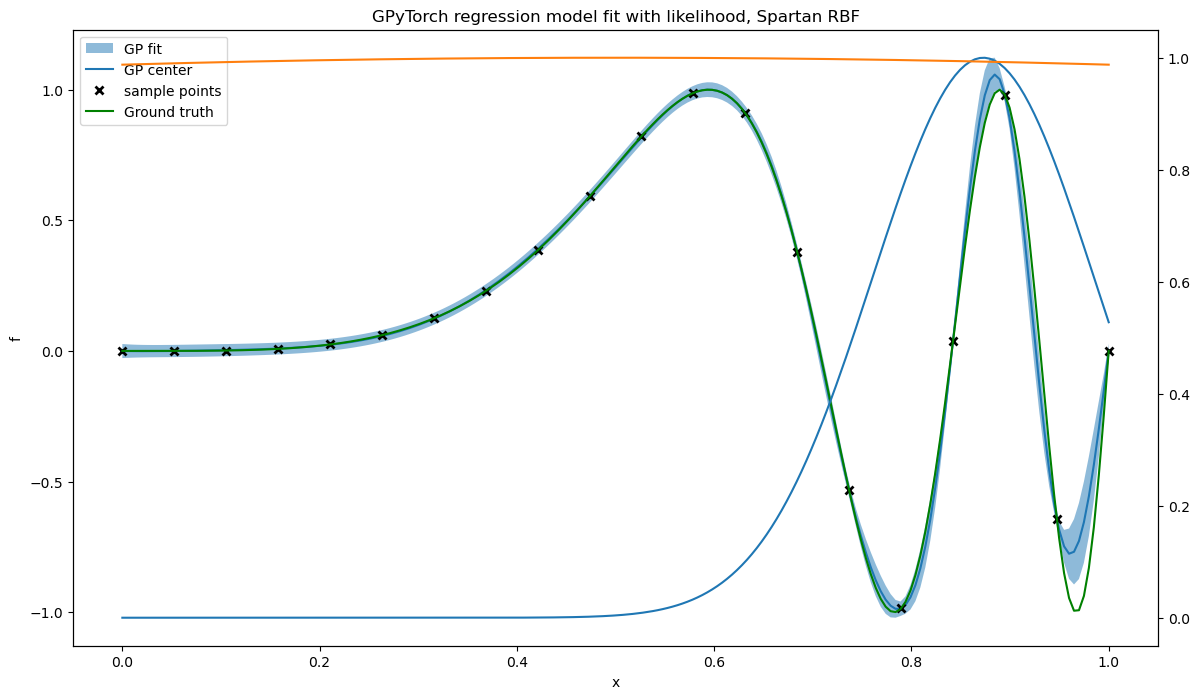

In [143]:
import timeit
Xt = Xt.cpu()
Yt = Yt.cpu()

start_time = timeit.default_timer()
# Spartan
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = Interval(lower_bound=1e-6, upper_bound = 1))
#likelihood = gpytorch.likelihoods.GaussianLikelihood()
model0.covar_module.base_kernel._set_local_position(0.5)
#for lk in model0.covar_module.base_kernel.local_kernels:
#    lk.raw_lengthscale_constraint = Interval(lower_bound=0.05, 
#                                             upper_bound=0.2)
model0.train()
likelihood.train()
training_iter = 10
'''
optimizer = torch.optim.Adam(model0.parameters(), lr=0.01)
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model0)
losstrack = 100
lossdif = 100
numcount = 0
steplength = torch.tensor([1])
#model0.likelihood.noise_covar.raw_noise.requires_grad_(False)
while(lossdif>5e-5 or steplength>0.005):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model0(Xt)
    # Calc loss and backprop gradients
    loss = -mll(output, Yt)
    lossdif = losstrack - loss.item()
    losstrack = loss.item()
    loss.backward()
    steplength = torch.norm(torch.as_tensor([param.grad for name, param in model0.named_parameters()]))
    if not(numcount%10):
        print('Iter %d - Loss: %.3f noise: %.3f variance: %.3f position: %.3f'  % (
            numcount + 1, loss.item(),
            #model.covar_module.base_kernel.lengthscale.item(),
            model0.likelihood.noise.item(),
            model0.covar_module.outputscale.item(),
            model0.covar_module.base_kernel.local_position.item()
        ))
        print("Step length:", steplength.item())

    optimizer.step()
    numcount += 1
'''

optimizer = torch.optim.LBFGS(model0.parameters(), lr=0.11, line_search_fn="strong_wolfe")
# "Loss" for GPs - the marginal log likelihood
#model0.likelihood.noise_covar.raw_noise.requires_grad_(False)

losstrack = 100
lossdif = 100
numcount = 0
steplength = torch.tensor([1])
for i in range(training_iter):
    def closure():
        # Zero gradients from previous iteration
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model0)
        optimizer.zero_grad()
        # Output from model
        output = model0(Xt)
        # Calc loss and backprop gradients
        loss = -mll(output, Yt)
        loss.backward()
        return loss
        
    optimizer.step(closure)
    loss = closure()
    print('Iter %d - Loss: %.3f noise: %.3f variance: %.3f position: %.3f locallengthscale: %.3f globallengthscale: %.3f localweightvar: %.3f'  % (
            i + 1, loss.item(),
            #model.covar_module.base_kernel.lengthscale.item(),
            model0.likelihood.noise.item(),
            model0.covar_module.outputscale.item(),
            model0.covar_module.base_kernel.local_position.item(),
            model0.covar_module.base_kernel.local_kernels[0].lengthscale.item(),
            model0.covar_module.base_kernel.global_kernel.lengthscale.item(),
            model0.covar_module.base_kernel.local_weight_var[0].item()
        ))
model0.eval()
likelihood.eval()

end_time = timeit.default_timer()

elapsed_time = end_time - start_time
print(f'Time elapsed: {elapsed_time} seconds')

Xtnew = torch.linspace(0,1,200)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model0(Xtnew)) # With noise liklihood
plt.figure(figsize=(14, 8))
# Plot the GP fit mean and covariance
plot_gptorch(Xtnew, observed_pred.mean, observed_pred.variance.detach(), 
             training_points=(Xt, Yt))
plt.plot(Xtnew, yt_func(Xtnew), 'g')
plt.legend(labels=["GP fit", "GP center", "sample points", "Ground truth"])
weights = plt.twinx()
#model0.covar_module.base_kernel.local_weight_var = model0.covar_module.base_kernel.local_weight_var/2
weights.plot(Xtnew.numpy(), model0.covar_module.base_kernel.omega_l(Xtnew.unsqueeze(-1),
firstkernel=True).detach().numpy())
weights.plot(Xtnew.numpy(), model0.covar_module.base_kernel.omega_g(Xtnew.unsqueeze(-1)).detach().numpy())
plt.title("GPyTorch regression model fit with likelihood, Spartan RBF")